In [181]:
import pymc3 as pm
from pymc3.glm import glm
import numpy as np
import pandas as pd
import datetime
import scipy.stats

from scipy import optimize
import theano as thno
import theano.tensor as T

# data retrieval helper module
from general.DB import DB
import util

from sklearn.linear_model import LinearRegression

# plotting libraries
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
%matplotlib inline

In [2]:
def evaluate(traces, true_coefs, var_prefix):
    df = pm.df_summary(traces[500:])
    df_coef = df.loc[['%s%s' % (var_prefix, i) for i in range(num_teams - 1)]]
    df_coef['hpd_2.5a'] = df_coef['hpd_2.5'].map(lambda x: x + true_coefs[-1])
    df_coef['hpd_97.5a'] = df_coef['hpd_97.5'].map(lambda x: x + true_coefs[-1])
    df_coef['mean_a'] = df_coef['mean'].map(lambda x: x + true_coefs[-1])
    df_coef['true'] = true_coefs[:-1]
    df_coef['captured'] = df_coef.apply(lambda row: (row['true'] > row['hpd_2.5a']) and (row['true'] < row['hpd_97.5a']), 1)
    print('Captured %s of %s' % (df_coef['captured'].sum(), df_coef['captured'].count()))
    return df_coef

In [18]:
def gen_data(N, num_teams, intercept=70):
    np.random.seed(13)
    indices = np.array([np.random.choice(list(range(num_teams)), 2, replace=False) for x in range(N)])
    data = []
    for idx in indices:
        x = np.zeros(num_teams)
        x[idx] = 1
        data.append(x)
    data = np.array(data)
    true_coefs = np.random.normal(0, 3, num_teams)
    true_coefs = true_coefs - np.mean(true_coefs)
    true_intercept = intercept
    
    mus = np.dot(data, true_coefs[:, np.newaxis]) + true_intercept
    std = 5
    return data, np.random.normal(mus, std), indices, true_coefs

In [275]:
def gen_data2(N, num_samples):
    np.random.seed(23)
    mus = np.random.random(N) * 20
    centered_mus = mus - np.mean(mus)
    indices = np.random.randint(0, N, num_samples)
    sample_mus = centered_mus[indices]
    samples = np.random.normal(sample_mus + 60., 5)
    return samples, mus, centered_mus, stds, indices

In [276]:
# p = []
# for idx in range(1000):
#     s = samples[np.where(indices == idx)]
#     mean = true_mus[idx]
#     sigma = 5 / np.sqrt(s.shape[0])
#     sample_mean = np.mean(s)
#     p.append(np.abs(scipy.stats.norm.cdf(sample_mean, loc=mean, scale=sigma) - 0.5))
# p = np.array(p)

In [277]:
samples, true_mus, centered_mus, stds, indices = gen_data2(200, 1000)
num_dists = true_mus.shape[0]
# true_mus.shape, np.unique(indices)

In [278]:
with pm.Model() as model2:
    mus = pm.Uniform('coefs', -200, 200, shape=num_dists)
#     centered = pm.Deterministic('centered', mus - T.mean(mus))
#     centered = pm.Deterministic('centered', coefs - T.mean(coefs))
#     intercept = pm.Normal('intercept', mu=70, sd=5)
    std = pm.HalfCauchy('std', beta=10, testval=1.)
    
    sample_mus = mus[indices]
    target = pm.Normal('target', mu=sample_mus, sd=std, observed=samples.ravel())
    start = pm.find_MAP()
#     step = pm.Metropolis(scaling=0.8) # Instantiate MCMC sampling algorithm
#     step = pm.BinaryMetropolis([mus])
#     step2 = pm.NUTS([std])
    traces = pm.sample(2000, progressbar=True)

Applied interval-transform to coefs and added transformed coefs_interval to model.
Applied log-transform to std and added transformed std_log to model.
Assigned NUTS to coefs_interval
Assigned NUTS to std_log
 [-----------------100%-----------------] 2000 of 2000 complete in 4.9 sec

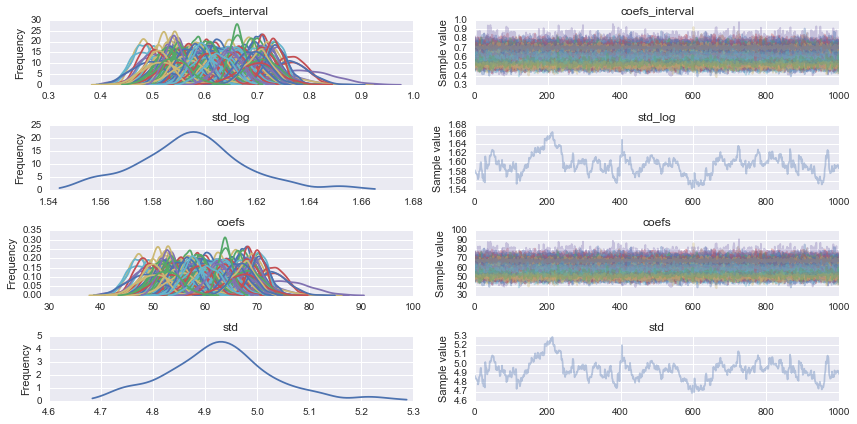

In [279]:
history = 1000
_ = pm.traceplot(traces[-history:], figsize=(12, len(traces.varnames) * 1.5))

In [274]:
df = pm.df_summary(traces[-history:])
df_coef = df.loc[['coefs__%s' % i for i in range(num_dists)]]
df_coef['true'] = centered_mus + 60.
df_coef['captured'] = df_coef.apply(lambda row: (row['true'] > row['hpd_2.5']) and (row['true'] < row['hpd_97.5']), 1)
df_coef['captured'].mean()

0.93500000000000005

In [25]:
N, num_teams = 2000, 100
X, y, indices, true_coefs = gen_data(N, num_teams)
hidx = indices[:, 0]
aidx = indices[:, 1]
data_df = pd.DataFrame(X, columns=[["x%s" % i for i in range(num_teams)]])
data_df['y'] = y
Xs = X[:, list(range(num_teams - 1))]
lr = LinearRegression()
lr.fit(Xs, y)
# lr.coef_
np.mean(y)

69.836316079656072

In [54]:
with pm.Model() as model:
    coefs = pm.Normal('coefs', mu=0, sd=3, shape=num_teams)
    centered = pm.Deterministic('centered', coefs - T.mean(coefs))
    intercept = pm.Normal('intercept', mu=70, sd=5)
    std = pm.HalfCauchy('std', beta=10, testval=1.)
    
    mus = centered[hidx] + centered[aidx] + intercept
    target = pm.Normal('target', mu=mus, sd=std, observed=y.ravel())
    start = pm.find_MAP()
#     step = pm.Metropolis(scaling=0.8) # Instantiate MCMC sampling algorithm
    step = pm.Metropolis()
    traces = pm.sample(2000, step, progressbar=True)

Applied log-transform to std and added transformed std_log to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 0.6 sec

In [61]:
with model:
    traces = pm.sample(10000, step, progressbar=True)

 [-----------------100%-----------------] 10000 of 10000 complete in 2.8 sec

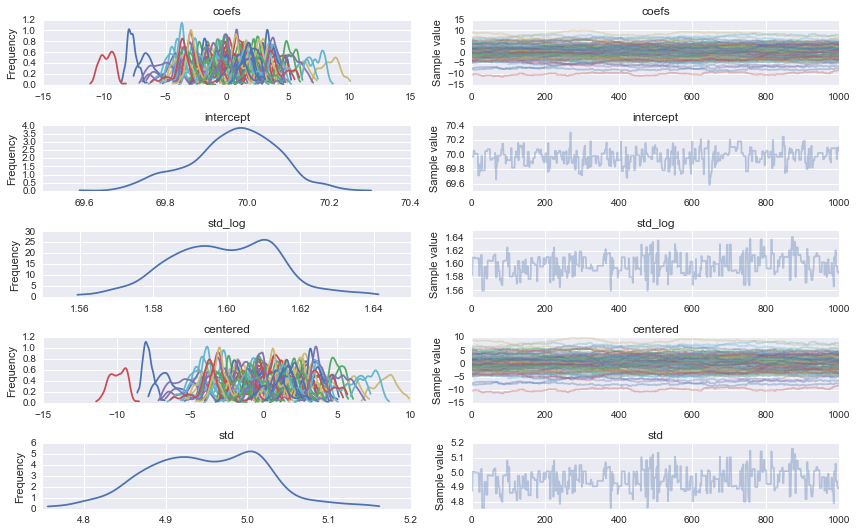

In [62]:
history = 1000
_ = pm.traceplot(traces[-history:], figsize=(12, len(traces.varnames) * 1.5))

In [63]:
df = pm.df_summary(traces[-history:]).loc[["centered__%s" % i for i in range(num_teams)]]
df['true'] = true_coefs
df['captured'] = df.apply(lambda row: (row['true'] > row['hpd_2.5']) and (row['true'] < row['hpd_97.5']), 1)
df['captured'].mean()

0.76000000000000001

In [267]:
# ppc = pm.sample_ppc(traces, samples=500, model=model, size=100)

In [38]:
# ppc['target'].shape

In [39]:
# ax = plt.subplot()
# sns.distplot([n.mean() for n in ppc['target']], kde=False, ax=ax)
# ax.axvline(np.mean(y))
# ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');
# ax.hist(y, bins=20)

In [40]:
# df_coef = evaluate(traces, true_coefs, 'centered__')

In [290]:
df = pm.df_summary(traces[start:])
df_coef = df.loc[['coefs__%s' % i for i in range(num_teams -1)]]
df_coef['hpd_2.5a'] = df_coef['hpd_2.5'].map(lambda x: x + true_coefs[0])
df_coef['hpd_97.5a'] = df_coef['hpd_97.5'].map(lambda x: x + true_coefs[0])
df_coef['mean'] = df_coef['mean'].map(lambda x: x + true_coefs[0])
df_coef['true'] = true_coefs[1:]
df_coef['captured'] = df_coef.apply(lambda row: (row['true'] > row['hpd_2.5a']) and (row['true'] < row['hpd_97.5a']), 1)
df_coef

,mean,sd,mc_error,hpd_2.5,hpd_97.5,hpd_2.5a,hpd_97.5a,true,captured
coefs__0,-0.880296,0.510005,0.017795,-6.671404,-4.698732,-1.863199,0.109473,-1.016070,True
coefs__1,-4.802647,0.533342,0.018480,-10.634383,-8.561390,-5.826178,-3.753185,-4.998406,True
coefs__2,1.213636,0.550840,0.016947,-4.702419,-2.531639,0.105786,2.276566,2.306779,False
coefs__3,2.382954,0.526194,0.016883,-3.416959,-1.364498,1.391246,3.443707,1.981471,True
coefs__4,4.955927,0.533170,0.017979,-0.950725,1.166648,3.857480,5.974853,4.919388,True
coefs__5,2.465292,0.510733,0.016425,-3.313262,-1.317501,1.494943,3.490704,2.072833,True
coefs__6,0.834185,0.530104,0.017033,-5.009453,-2.878346,-0.201248,1.929859,1.060165,True
coefs__7,-0.233277,0.504594,0.016933,-5.994876,-4.051446,-1.186671,0.756759,-0.629444,True
coefs__8,-1.102967,0.538483,0.017630,-6.994665,-4.887939,-2.186460,-0.079733,-1.233574,True


In [284]:
df_intercept = df.loc['intercept']
lb = df_intercept['hpd_2.5'] - 2 * true_coefs[0]
ub = df_intercept['hpd_97.5'] - 2 * true_coefs[0]
lb, ub

(68.131215089369604, 71.168663246601142)

In [243]:
with pm.Model() as model2:
    coefs = pm.Normal('coefs', mu=0, sd=3, shape=num_teams)
    coefs_centered = pm.Deterministic("coefs_centered", coefs - coefs.mean())
    intercept = pm.Normal('intercept', mu=65, sd=5)
    std = pm.Uniform('std', 0.1, 10)
    
    mus = T.dot(X, coefs_centered) + intercept
    target = pm.Normal('target', mu=mus, sd=std, observed=y.ravel())

Applied interval-transform to std and added transformed std_interval to model.


In [244]:
with model2:
    step = pm.NUTS([coefs, coefs_centered, intercept, mus, target])
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell)
    traces2 = pm.sample(5000, start=start_MAP, step=step, progressbar=True)

Assigned NUTS to std_interval
 [-----------------100%-----------------] 5000 of 5000 complete in 9.0 sec

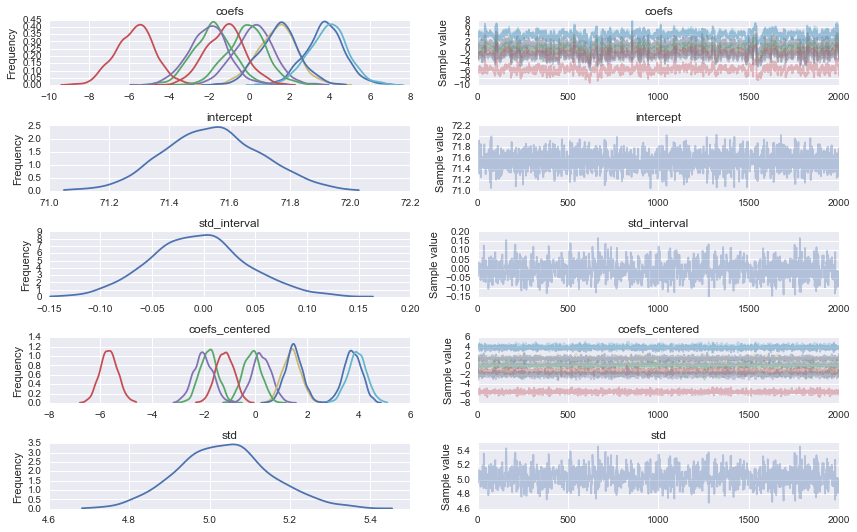

In [245]:
start = 3000
_ = pm.traceplot(traces2[start:], figsize=(12, len(traces2.varnames) * 1.5))

In [251]:
df2 = pm.df_summary(traces2[start:])
df_coef2 = df2.loc[['coefs__%s' % i for i in range(num_teams)]]

df_coef2['true'] = true_coefs
df_coef2['captured'] = df_coef2.apply(lambda row: (row['true'] > row['hpd_2.5']) and (row['true'] < row['hpd_97.5']), 1)
df_coef2

,mean,sd,mc_error,hpd_2.5,hpd_97.5,true,captured
coefs__0,3.733601,0.989592,0.054474,1.830707,5.724334,4.808205,True
coefs__1,-1.838036,1.001350,0.055106,-3.709525,0.172429,-1.016070,True
coefs__2,-5.703530,0.996591,0.054173,-7.708654,-3.842971,-4.998406,True
coefs__3,0.206641,1.005813,0.055314,-1.822448,2.119588,2.306779,False
coefs__4,1.369979,0.997607,0.053998,-0.627585,3.389471,1.981471,True
coefs__5,3.912084,0.990506,0.052230,1.946499,5.784824,4.919388,True
coefs__6,1.453730,0.996191,0.054479,-0.515667,3.405518,2.072833,True
coefs__7,-0.156079,1.002977,0.054177,-2.243687,1.676332,1.060165,True
coefs__8,-1.213407,0.990005,0.054096,-3.123791,0.772484,-0.629444,True
coefs__9,-2.056864,1.001527,0.053569,-4.263357,-0.284382,-1.233574,True


In [248]:
true_coefs

array([ 4.80820529, -1.01606991, -4.99840605,  2.306779  ,  1.98147096,
        4.91938763,  2.07283298,  1.06016512, -0.62944443, -1.23357366])

In [135]:
N, num_teams = 100, 10
X, y, true_coefs = gen_data(N, num_teams, intercept=0)
Xs = X[:, list(range(1, num_teams))]
# np.cov(Xs.T)

In [146]:
XTX = np.concatenate([np.dot(X.T, X), np.ones(num_teams)[:, np.newaxis]], 1)
XTX = np.dot(X.T, X)
XTX2 = XTX.copy().ravel()
XTX2[-num_teams:] = 1
XTX2 = XTX2.reshape(num_teams, num_teams)
XTy = np.dot(X.T, y)
XTy2 = XTy.copy()
XTy2[-1] = 0
# XTX2, XTy2, XTy
XTX

array([[ 17.,   0.,   3.,   6.,   2.,   1.,   0.,   0.,   1.,   4.],
       [  0.,  23.,   5.,   1.,   3.,   2.,   6.,   1.,   2.,   3.],
       [  3.,   5.,  23.,   2.,   4.,   3.,   0.,   0.,   4.,   2.],
       [  6.,   1.,   2.,  21.,   1.,   2.,   0.,   5.,   2.,   2.],
       [  2.,   3.,   4.,   1.,  20.,   3.,   1.,   1.,   0.,   5.],
       [  1.,   2.,   3.,   2.,   3.,  19.,   1.,   4.,   2.,   1.],
       [  0.,   6.,   0.,   0.,   1.,   1.,  14.,   3.,   1.,   2.],
       [  0.,   1.,   0.,   5.,   1.,   4.,   3.,  22.,   4.,   4.],
       [  1.,   2.,   4.,   2.,   0.,   2.,   1.,   4.,  17.,   1.],
       [  4.,   3.,   2.,   2.,   5.,   1.,   2.,   4.,   1.,  24.]])

In [154]:
pinv = np.linalg.pinv(XTX)
beta = np.dot(pinv, XTy)
beta

array([[-3.24439961],
       [ 0.33642119],
       [-2.80316527],
       [-1.20514678],
       [ 1.03204852],
       [-2.76813524],
       [-4.11945125],
       [ 1.88179029],
       [ 0.41666989],
       [-2.50549569]])

In [155]:
true_coefs

array([-2.11381429,  1.36595558, -3.66201571, -1.69513955,  2.11856643,
        0.01513169, -2.61977754,  1.66805424,  0.80214593, -3.09580448])

In [149]:
lambdas, V =  np.linalg.eig(XTX)
# The linearly dependent row vectors 
print(XTX[lambdas == 0,:])

[]


In [215]:
X2 = np.concatenate([X, np.ones(X.shape[0])[:, np.newaxis]], 1)
np.linalg.cond(X)

1.8981426341043044

In [217]:
lr.fit(Xs, y)
y_pred = lr.predict(Xs)

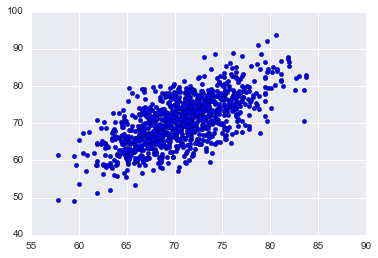

In [219]:
plt.scatter(y_pred, y)